In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np

from collections import defaultdict
from tqdm.notebook import tqdm

# Часть третья: расширим и углубим поиск

In [2]:
class TicTacToe:
    def __init__(self, rows, cols, wins):
        self.board = np.zeros((rows, cols), dtype = int)
        self.done = False
        self.player = 1
        self.rows = rows
        self.cols = cols
        self.wins = wins

    def update_state(self, position):
        self.board[position] = self.player
        self.player = -1 if self.player == 1 else 1
        self.is_terminal()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype = int)
        self.done = False
        self.player = 1

    def available_positions(self,):
        data = np.where(self.board==0)
        positions = list(zip(data[0], data[1]))
        return positions
    
    def is_terminal(self):
        for i in range(self.rows):
            sum_row = np.sum(self.board[i, :])
            sum_col = np.sum(self.board[:, i])
            if sum_row == self.wins or sum_col == self.wins:
                self.done = True
                return 1
            elif sum_row == -self.wins or sum_col == -self.wins:
                self.done = True
                return -1
        
        diag_sum1 = 0
        diag_sum2 = 0
        for i in range(self.cols):
            diag_sum1 += self.board[i, i]
            diag_sum2 += self.board[i, self.cols - i - 1]
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == self.wins:
            if diag_sum1 == self.wins or diag_sum2 == self.wins:
                self.done = True
                return 1
            else:
                self.done = True
                return -1
        
        if len(self.available_positions()) == 0:
            self.done = True
            return 0
        self.done = False
        return None
    
    def copy_board(self):
        tmp = TicTacToe(self.rows, self.cols, self.wins)
        tmp.board = self.board.copy()
        tmp.done = self.done
        tmp.player = self.player
        return tmp
        
    def steps(self, type_="available"):
        if type_ == "available":
            boards = []
            if self.done == False:
                for pos in self.available_positions():
                    board = self.copy_board()
                    board.update_state(pos)
                    boards.append(board)
            return set(boards)
        else:
            if self.done == True:
                return None
            board = self.copy_board()
            board.update_state(random.choice(board.available_positions()))
            return board
    
    def get_hash(self):
        return self.board.tobytes()
    
    def __hash__(self):
        return hash(self.board.tobytes())
    
    def __eq__(self, other):
        return self.get_hash() == other.get_hash()

In [3]:
class MCTS:
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)
        self.N = defaultdict(int)
        self.children = dict()
        self.exploration_weight = exploration_weight

    def _relations(self, n):
        if self.N[n] == 0:
            return float("-inf")
        return self.Q[n] / self.N[n]

    def _choice(self, node):
        if node not in self.children:
            return node.steps("random")
        return max(self.children[node], key=self._relations)
    
    def _rollout(self, node):
        path = self._select(node)
        self._expand(path[-1])
        reward = self._playout(path[-1])
        self._set_values(path, reward)
    
    def _select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            for n in self.children[node]:
                if n not in self.children:
                    path.append(n)
                    return path
            node = self._uct_select(node)

    def _expand(self, node):
        if node in self.children:
            return
        self.children[node] = node.steps("available")

    def _playout(self, node):
        while node.done == False:
            node = node.steps("random")
        return node.is_terminal()

    def _set_values(self, path, reward):
        for node in path[::-1]:
            self.N[node] += 1
            self.Q[node] += reward
    
    def _uct_select(self, node):
        assert all(n in self.children for n in self.children[node])
        if node.player == -1:
            return node.steps("random")
        vertex = math.log(self.N[node])
        
        def uct(n):
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(vertex / self.N[n])
        
        return max(self.children[node], key=uct)
    
    def _run_episode(self, game, rollouts=30, do_learning=True):
        game.reset()
        while game.done == False:
            if do_learning:
                for _ in range(rollouts):
                    self._rollout(game)
            game = self._choice(game)
            if game.done == False:
                game = game.steps("random")
        return game.is_terminal()
    
    def fit(self, size_deck=3, train_games=10000, val_step=1000, val_games=10000):
        self._fig, self._ax = plt.subplots(figsize=(8, 6))
        dict_data = {-1:[], 0:[], 1:[]}
        mean_data = []
        data_x = []
        
        game = TicTacToe(size_deck, size_deck, size_deck)

        for i in tqdm(range(train_games + 1)):
            self._run_episode(game)
            if i % val_step == 0:
                counts = 0
                dict_res = {-1:0, 0:0, 1:0}
                for j in range(val_games):
                    res = self._run_episode(game, do_learning=False)
                    dict_res[res] += 1
                    counts += res
                data_x.append(i)
                mean_data.append(counts/val_games)
                dict_data[1].append(dict_res[1]/val_games)
                dict_data[0].append(dict_res[0]/val_games)
                dict_data[-1].append(dict_res[-1]/val_games)
                self._draw_plot(train_games, data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])
                
    def _draw_plot(self, rounds, data_x, data_y, data_y1, data_y2, data_y3):
        self._ax.clear()
        self._ax.plot(data_x, data_y1, 'go-', label='Доля побед')
        self._ax.plot(data_x, data_y2, 'b^--', label='Доля ничьих')
        self._ax.plot(data_x, data_y3, 'rs-.', label='Доля поражений')
        self._ax.set_title('Исходы игры',
                           fontdict={'fontsize': 12},
                          )
        self._ax.set_ylabel('Доля побед, ничьих, поражений',
                            fontdict={'fontsize': 10},
                           )
        self._ax.set_xlabel('Итерации обучения',
                            fontdict={'fontsize': 10},
                           )
        self._ax.legend(loc='best')
        self._ax.set_xlim([0, rounds])
        self._ax.set_ylim([0, 1.0])
        self._fig.canvas.draw()

## Крестики-нолики 3x3 

<IPython.core.display.Javascript object>


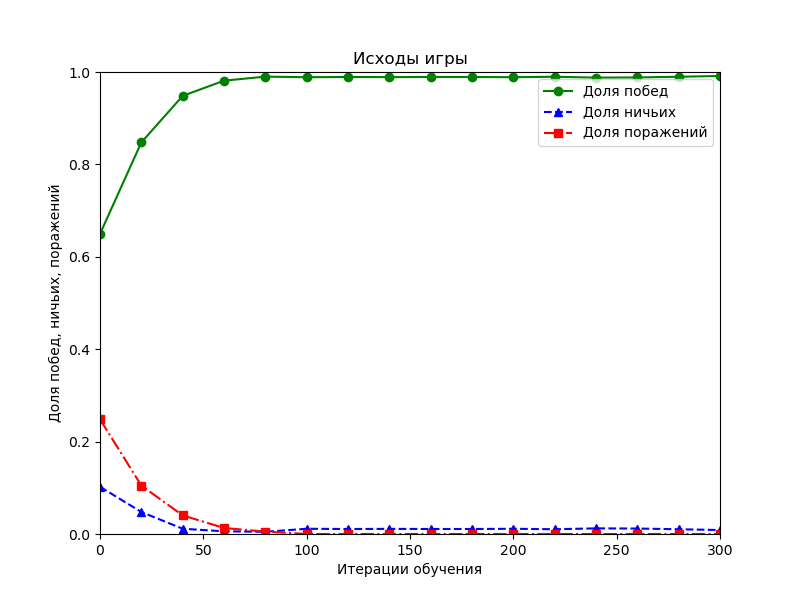

In [4]:
%matplotlib notebook

mcts = MCTS(exploration_weight=1)

mcts.fit(size_deck=3, 
         train_games=300, 
         val_step=20, 
         val_games=10000,
        )

## Крестики-нолики 4x4

<IPython.core.display.Javascript object>


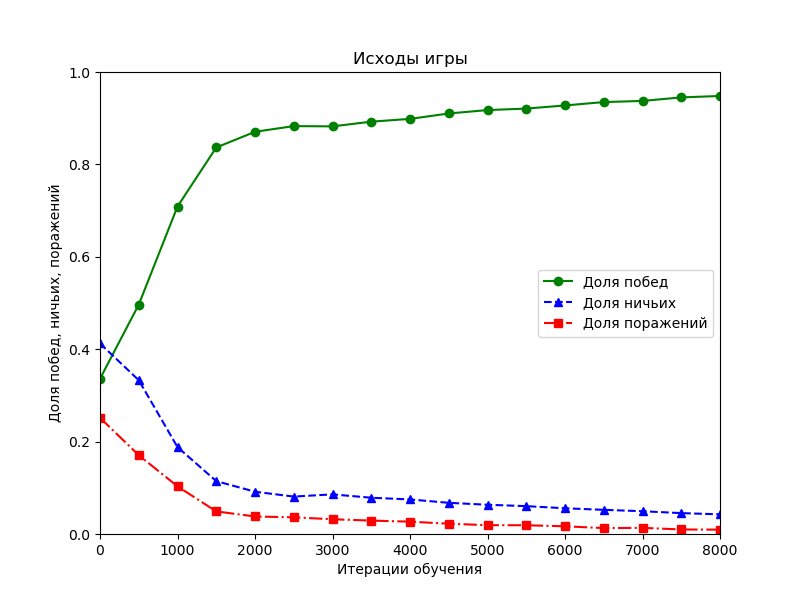

In [5]:
%matplotlib notebook

mcts = MCTS(exploration_weight=1)

mcts.fit(size_deck=4, 
         train_games=8000, 
         val_step=500, 
         val_games=10000,
        )